<a href="https://colab.research.google.com/github/Shegy12/GAN-for-generating-artificial-ECG-data/blob/master/GAN_1D_functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Simple GAN model for generating 1D functions**

## **Installing keras deep learning library**

In [2]:
!pip3 install scipy keras

## **Imports**

In [2]:
# Jupyter notebook related
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# Built-in modules
import sys
import os
import datetime
from enum import Enum
from pathlib import Path

#keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
from keras.layers import LeakyReLU

# numpy
from numpy import zeros
from numpy import ones
from numpy import hstack
from numpy.random import rand
from numpy.random import randn
from numpy.random import randint

# Basics of Python data handling and visualization
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from matplotlib import pyplot
from timeit import default_timer as timer
# import rasterio

Using TensorFlow backend.


## **Google drive**

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

GOOGLE_DRIVE_PATH = Path('/content/gdrive/My Drive')
WORKDIR = 'ECG_DATA' # specify the path to folder which you are intend to work with in this notebook
WORKDIR_PATH = GOOGLE_DRIVE_PATH / WORKDIR

if not os.path.exists(WORKDIR_PATH):
          os.mkdir(WORKDIR_PATH)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## **Demonstrate simple x^2 function**
generate samples, generate real samples


vystup z realnych hodnot -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5 (11 hodnot)


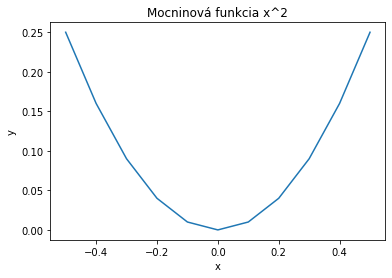

Random Real samples od -0,5 do 0,5


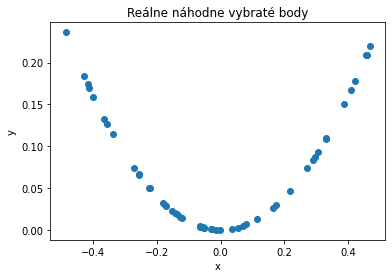

In [4]:
# demonstrate simple x^2 function
def calculate(x):
	return x * x

# generate randoms sample from x^2 - FUNKCIA

def generate_samples(n=100):
	X1 = rand(n) - 0.5
	#print(X1)
	X2 = X1 * X1
	# stack arrays - spojim dva stlpce X1 a X2
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	return hstack((X1, X2))  #vystup je v returne, dalej ukladam do x2_data 

# generate n REAL samples with class labels

def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1)) # tymto hovorim ze vsetky vygenerovane data su real, same jednotky
	return X, y

# define inputs
inputs = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5]
# calculate outputs
outputs = [calculate(x) for x in inputs]
# plot the result
print('vystup z realnych hodnot -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5 (11 hodnot)')
pyplot.plot(inputs, outputs)
pyplot.title('Mocninová funkcia x^2')
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.show()

# generate samples
x2_data = generate_samples(50)
print('Random Real samples od -0,5 do 0,5') 
# plot samples
pyplot.scatter(x2_data[:, 0], x2_data[:, 1])
pyplot.title('Reálne náhodne vybraté body')
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.show()

## **Define a Discriminator model**
diskrimator_model, loss, optimization, metrics

**Inputs:** Sample with two real values. (vstup1 : vstupny stlpec,vstup2: vystupny stlpec)

**Outputs:** Binary classification, likelihood the sample is real (or fake). 0/1

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                75        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


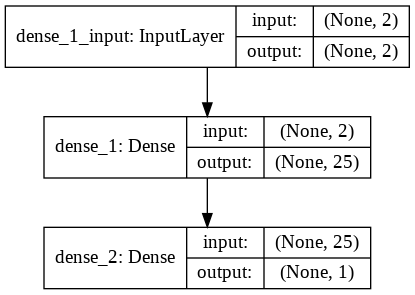

In [5]:
def define_discriminator(n_inputs=2):
	discriminator_model = Sequential() #The Sequential model is a linear stack of layers.
	# dense=2D layer, musi poznat imput - zadavam cez inputshape, imput dim - atd vid link
	discriminator_model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))  
	discriminator_model.add(Dense(1, activation='sigmoid'))
 

# definujeme loss funkciu,   optimalizer-sposob ucenia     metrics - hodnoti vykon,spravnost modelu = metric function is similar to a loss function, except that the results from evaluating a metric are not used when training the model. You may use any of the loss functions as a metric function.
# https://keras.io/losses/    https://keras.io/optimizers/    https://keras.io/metrics/

	# compile model
	discriminator_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return discriminator_model


# define the discriminator model
discriminator_model = define_discriminator()
# summarize the model
discriminator_model.summary()
# plot the model
plot_model(discriminator_model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)



## **Define a Generator Model**
generator model, latent points

Predict generatoru z latent points, 5 dimenzii,50 hodnot


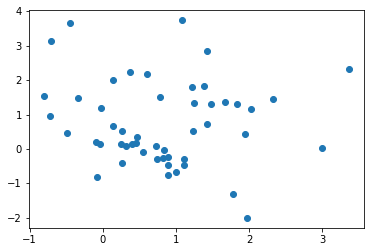

Model summary
Model: "sequential_53"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 15)                90        
_________________________________________________________________
dense_104 (Dense)            (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
_________________________________________________________________
Model plot


(0.0, 30.0)

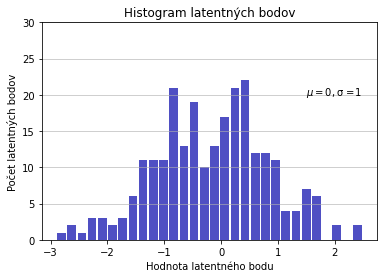

In [79]:
def define_generator(latent_dim, n_outputs=2):
	generator_model = Sequential()
	generator_model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim)) 
	generator_model.add(Dense(n_outputs, activation='linear'))
	return generator_model

#The first step is to generate new points in the latent space. We can achieve this by calling the randn() NumPy function for generating arrays of random numbers drawn from a standard Gaussian.

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n) 
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input
 
# size of the latent space
latent_dim = 5
# define the generator model
generator_model = define_generator(latent_dim)
# generate and plot generated samples
generate_fake_samples(generator_model, latent_dim, 50)

# summarize the model
print('Model summary')
generator_model.summary()
# plot the model
print('Model plot')
plot_model(generator_model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

latent_std=1
latent_mean=0
latent_points=generate_latent_points(5,50)
latent_points=latent_points.reshape(250)
n, bins, patches = plt.hist(x=latent_points, bins=30, color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Hodnota latentného bodu')
plt.ylabel('Počet latentných bodov')
plt.title('Histogram latentných bodov')
plt.text(1.5, 20, r'$\mu =0, $σ =1')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)


## **Define GAN**

The weights in the generator model are updated based on the performance of the discriminator model. When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

**The generator model is only concerned with the discriminator’s performance on fake examples.**
Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

When training the generator via this subsumed GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. 
Therefore, **when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).**

We can imagine that the discriminator will then classify the generated samples as not real (class 0) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this 
as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating plausible fake samples.

**Inputs:** Point in latent space, e.g. a five-element vector of Gaussian random numbers.

**Outputs:** Binary classification, likelihood the sample is real (or fake).


Gan model summary :
Model: "sequential_58"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_56 (Sequential)   (None, 2)                 122       
_________________________________________________________________
sequential_57 (Sequential)   (None, 1)                 101       
Total params: 223
Trainable params: 122
Non-trainable params: 101
_________________________________________________________________
Gan model plot: 


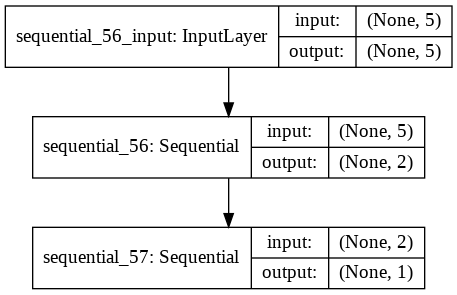

In [88]:
# define the combined generator and discriminator model, for updating the generator

def define_gan(generator_model, discriminator_model):
	# make weights in the discriminator not trainable
	discriminator_model.trainable = False
	# connect them
	gan_model = Sequential()
	# add generator
	gan_model.add(generator_model)
	# add the discriminator
	gan_model.add(discriminator_model)
	# compile model
	gan_model.compile(loss='binary_crossentropy', optimizer='adam')
	return gan_model

# create the gan
gan_model = define_gan(generator_model, discriminator_model)
# summarize gan model
print('Gan model summary :')
gan_model.summary()
# plot gan model
print('Gan model plot: ')
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)


## **Final GAN Model** 
generating x^2 function

In [201]:
# DENSE VRSTVA 
# Just your regular densely-connected NN layer. (https://keras.io/layers/core/)
# Dense implements the operation: output = activation(dot(input, kernel) + bias) where activation is the element-wise activation function passed as the activation argument, 
# kernel is a weights matrix created by the layer, and bias is a bias vector created by the layer (only applicable if use_bias is True).

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# define the standalone DISCRIMINATOR model

# vstup 2 vektory 1D hodnot- vstup1[x,x^2], vstup2[label]
# vystup 25 neuronov vrstva FCNN
# AKTIVACNA FUNKCIA : relu
# INICIALIZACIA VAH : he uniform

# vstup 25 (vystup z predchadzajucej)
# 1 neuron vystupna vrstva 
# AKTIVACNA FUNKCIA : sigmoid (0-1)

# LOSS FUNKCIA : binarna crossentropia
# OPTIMIZER : adam
# METRICS : accuracy

start = timer()

def define_discriminator(n_inputs=2):
	model = Sequential()
	model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# define the standalone GENERATOR model

# vstup su hodnoty (5) z latent space - 5 dimenzii = 5hodnot, dimenziu viem nastavit (five-element vector of Gaussian random numbers)
# 15 neuronov vrstva FCNN
# AKTIVACNA FUNKCIA : relu
# INICIALIZACIA VAH : he uniform

# vstup 15 (vystup z predchadzajucej)
# vystup 2 hodnoty x a y(x na druhu),
# AKTIVACNA FUNKCIA : linear
# Linear activation function is used because we know we want the generator to output a vector of real values and the scale will be [-0.5, 0.5 -x axes] 
# for the first element and about [0.0, 0.25 -y xes] for the second element.


def define_generator(latent_dim, n_outputs=2):
	model = Sequential()
	model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
	model.add(Dense(n_outputs, activation='linear'))
	return model

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# LOSS FUNKCIA : binarna crossentropia
# OPTIMIZER : adam

# define the combined generator and discriminator model, for updating the generator

def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# generate n real samples with class labels

def generate_real_samples(n):
	# generate inputs in [-0.5, 0.5]
	X1 = rand(n) - 0.5
	# generate outputs X^2
	X2 = X1 * X1
	# stack arrays
	X1 = X1.reshape(n, 1)
	X2 = X2.reshape(n, 1)
	X = hstack((X1, X2))
	# generate class labels
	y = ones((n, 1))
	return X, y

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space - 5x100 hodnot = 500 hodnot gaussovsky rozlozenych 
	# -> We will generate new inputs by drawing random numbers from a standard Gaussian distribution, i.e. mean of zero and a standard deviation of one.
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	pyplot.title('Iterácia :'+ "  " + str(epoch+1)+" | "+'acc_real ='+"  "+str(np.round(acc_real,4))+" | "+'acc_fake ='+"  "+str(np.round(acc_fake,4)))
	pyplot.show()
	if (acc_fake > 0.475) and (acc_fake < 0.525) and (acc_real > 0.475) and (acc_real < 0.525) and epoch>50000:
		print('Model is trained')
		a=1/0

#________________________________________________________________________________________________________________________________________________________________________________________________________________________________
#________________________________________________________________________________________________________________________________________________________________________________________________________________________________

# batch size - staci do 512
# epochy - kolko treba
# n_eval - po kolkych epochach vyhodnocovat

def train(generator_model, discriminator_model, gan_model, latent_dim, n_iter=100000, n_batch=512,n_eval=500):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch) # generator model instead of random numbers
		# update discriminator
		d_real_loss,d_real_acc=discriminator_model.train_on_batch(x_real, y_real)
		d_fake_loss,d_fake_acc=discriminator_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		g_loss=gan_model.train_on_batch(x_gan, y_gan)
		d_real_loss_graph.append(d_real_loss)
		d_real_acc_graph.append(d_real_acc)
		d_fake_loss_graph.append(d_fake_loss)
		d_fake_acc_graph.append(d_fake_acc)
		g_loss_graph.append(g_loss)
  # evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
		  summarize_performance(i, generator_model, discriminator_model, latent_dim)
	 
					
d_real_loss_graph=[]
d_real_acc_graph=[]
d_fake_loss_graph=[]
d_fake_acc_graph=[]
g_loss_graph=[]
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model
train(generator, discriminator, gan_model, latent_dim)

end = timer()
print(end - start)


(59,)

### Plotting losses and accuracies
x^2

In [0]:
filtered_list_real = [ item for i,item in enumerate(d_real_acc_graph) if i%100==0 ]
filtered_list_fake = [ item for i,item in enumerate(d_fake_acc_graph) if i%100==0 ]

time_axis=np.linspace(0,53000,530)
fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Presnosť na reálnych bodoch', 'x': time_axis, 'y': filtered_list_real[:], 'color':'r', 'linewidth':2.5},{'name': 'Presnosť na falošných bodoch', 'x': time_axis, 'y': filtered_list_fake[:], 'color':'b', 'linewidth':2.5}]
for signal in mysignals:
	#ax1 = fig.add_subplot(n, n, 1 + i)
	plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
	#ax1.axis('off')
	plt.legend(loc='upper right',prop={'size': 30})
	plt.xlabel('Iterácia',fontsize=20)
	plt.ylabel('Presnosť',fontsize=20)

time_axis=np.linspace(0,53000,53000)
d_loss_total= np.array(d_real_loss_graph)+np.array(d_fake_loss_graph)
fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Chyba diskriminátora', 'x': time_axis, 'y': d_loss_total[:], 'color':'r', 'linewidth':2.5},{'name': 'Chyba generátora', 'x': time_axis, 'y': g_loss_graph[:], 'color':'b', 'linewidth':2.5}]
for signal in mysignals:
	#ax1 = fig.add_subplot(n, n, 1 + i)
	plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
	#ax1.axis('off')
	plt.legend(loc='upper right',prop={'size': 30})
	plt.xlabel('Iterácia',fontsize=20)
	plt.ylabel('Hodnota chyby',fontsize=20)



## **Final GAN Model2**
generating sine function

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


9999 0.6399999856948853 0.4699999988079071


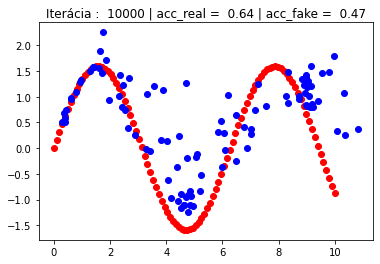

19999 0.7200000286102295 0.17000000178813934


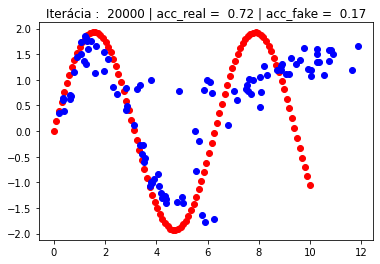

29999 0.20000000298023224 0.9399999976158142


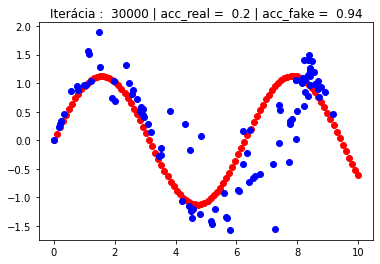

39999 0.7300000190734863 0.28999999165534973


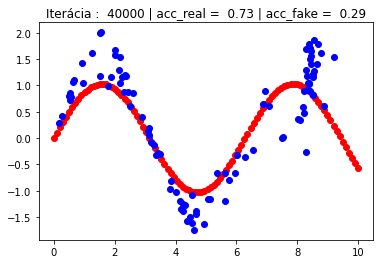

49999 0.7099999785423279 0.33000001311302185


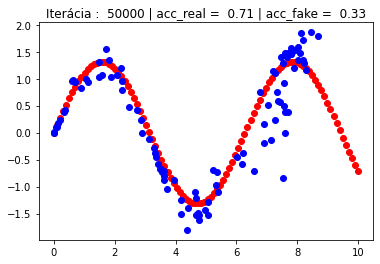

59999 0.5299999713897705 0.5


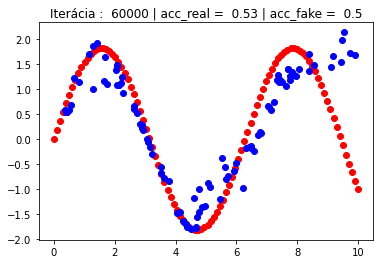

69999 0.1599999964237213 0.8899999856948853


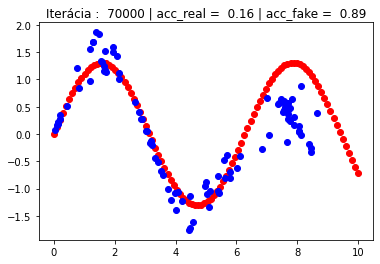

79999 0.3799999952316284 0.8199999928474426


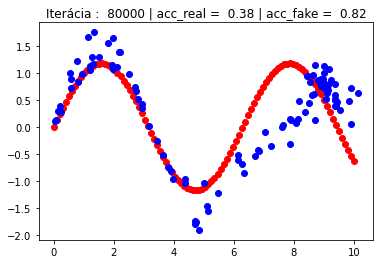

89999 0.3100000023841858 0.7799999713897705


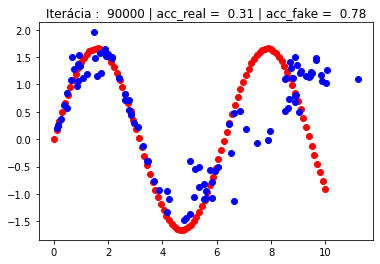

99999 0.20999999344348907 0.8899999856948853


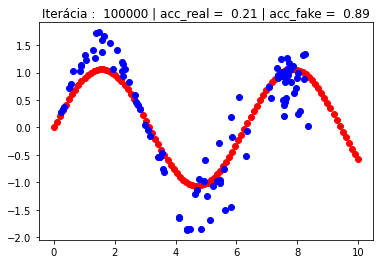

109999 0.1599999964237213 0.7699999809265137


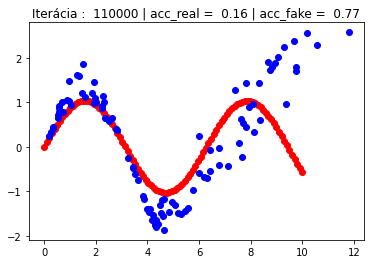

119999 0.5 0.5899999737739563


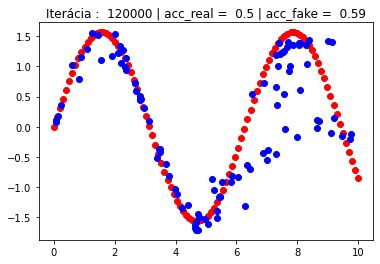

129999 0.28999999165534973 0.7599999904632568


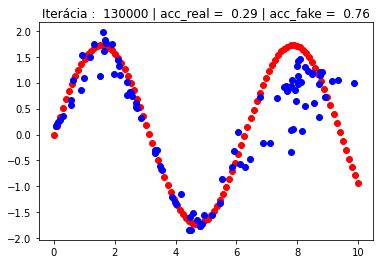

139999 0.6899999976158142 0.5299999713897705


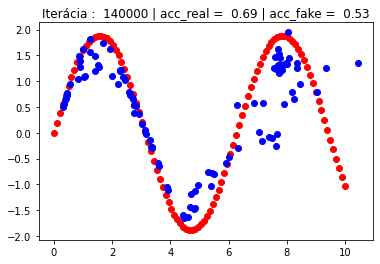

149999 0.5699999928474426 0.2800000011920929


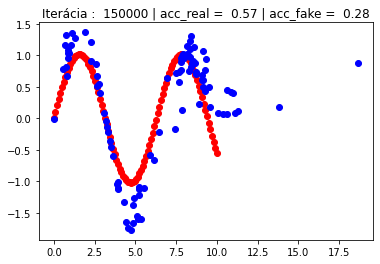

159999 0.3400000035762787 0.7799999713897705


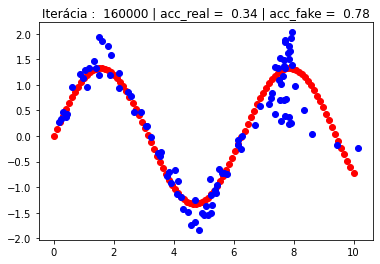

169999 0.3199999928474426 0.6100000143051147


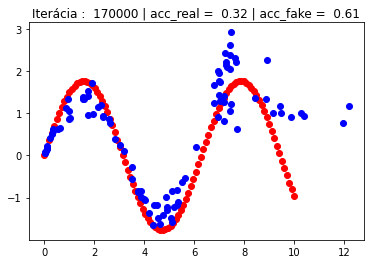

179999 0.8600000143051147 0.30000001192092896


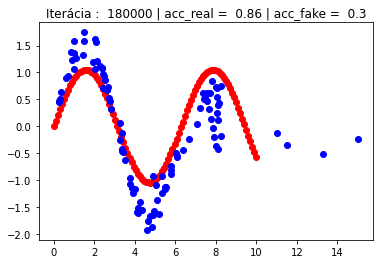

189999 0.8299999833106995 0.25


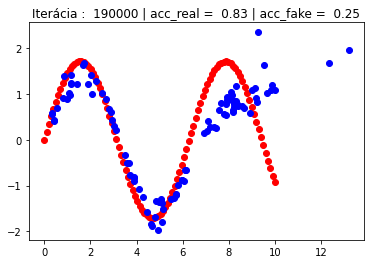

199999 0.7900000214576721 0.1599999964237213


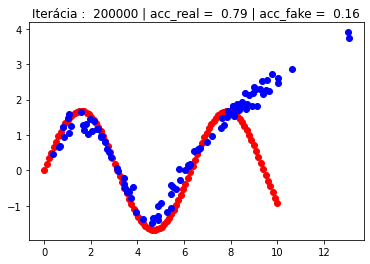

209999 0.23000000417232513 0.6800000071525574


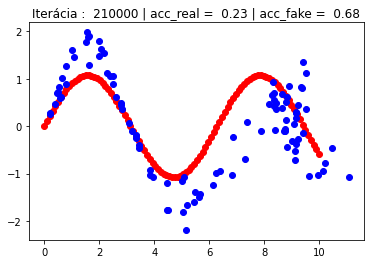

219999 0.09000000357627869 0.8700000047683716


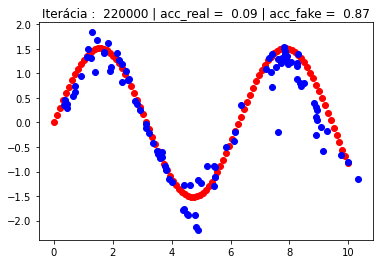

229999 0.44999998807907104 0.7200000286102295


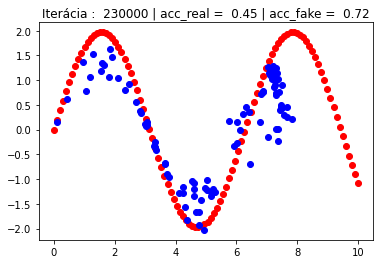

239999 0.7099999785423279 0.7200000286102295


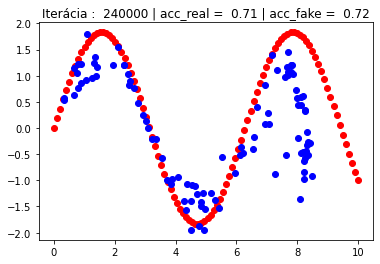

249999 0.3199999928474426 0.46000000834465027


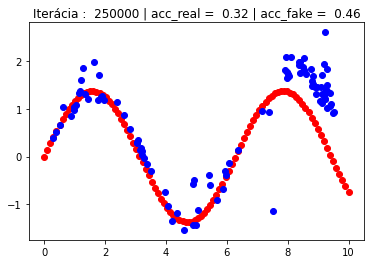

259999 0.6800000071525574 0.5


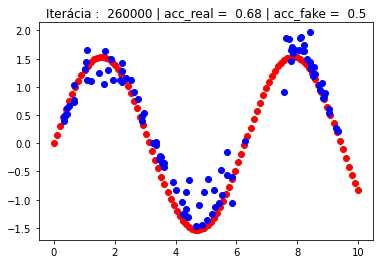

269999 0.38999998569488525 0.5299999713897705


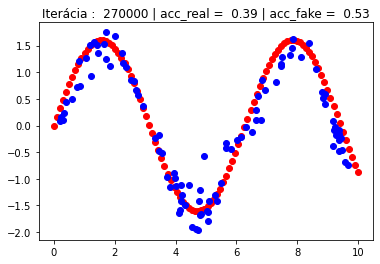

279999 0.49000000953674316 0.5600000023841858


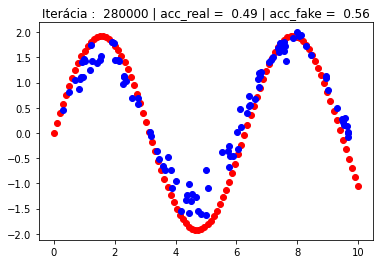

289999 0.23000000417232513 0.7400000095367432


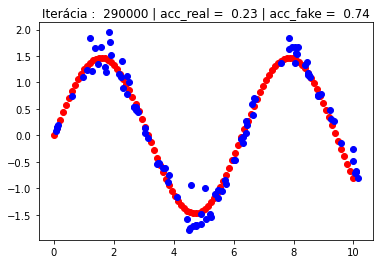

299999 0.4699999988079071 0.6399999856948853


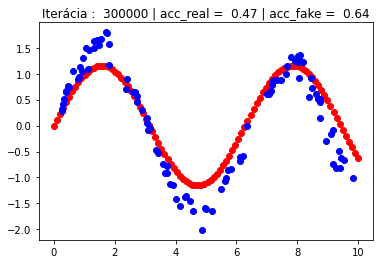

309999 0.41999998688697815 0.75


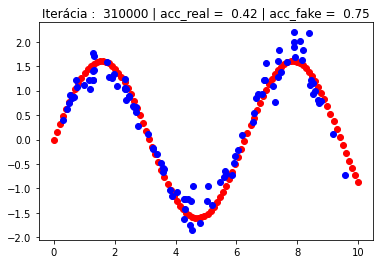

319999 0.5 0.6200000047683716


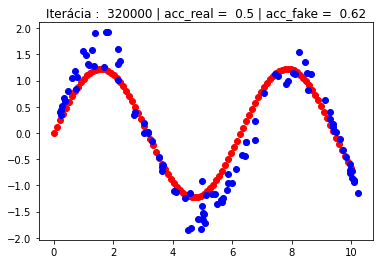

329999 0.6800000071525574 0.41999998688697815


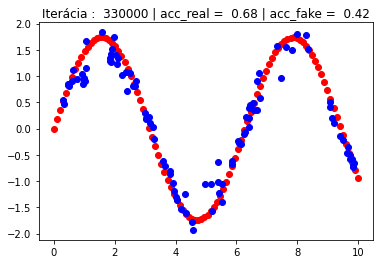

339999 0.3400000035762787 0.6100000143051147


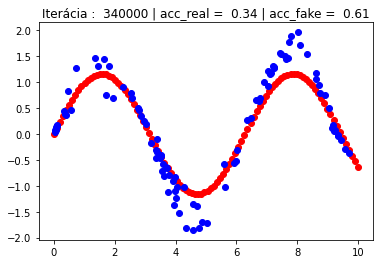

349999 0.6499999761581421 0.4099999964237213


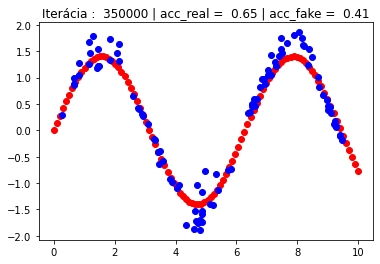

359999 0.5199999809265137 0.4099999964237213


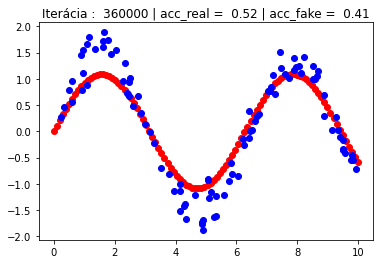

369999 0.6800000071525574 0.28999999165534973


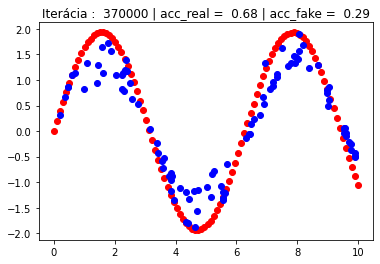

379999 0.6299999952316284 0.3499999940395355


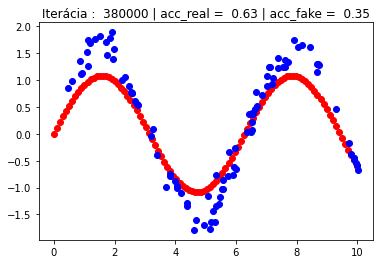

389999 0.25999999046325684 0.75


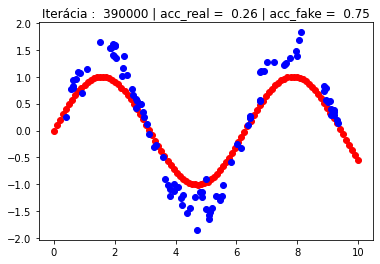

399999 0.27000001072883606 0.8700000047683716


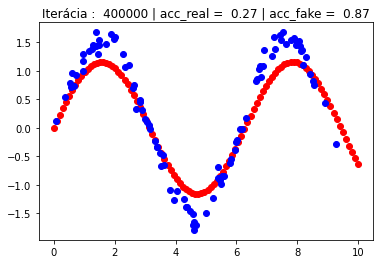

409999 0.3400000035762787 0.8299999833106995


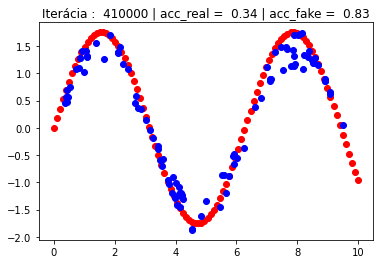

419999 0.30000001192092896 0.8199999928474426


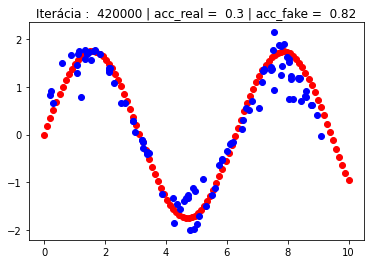

429999 0.2800000011920929 0.9100000262260437


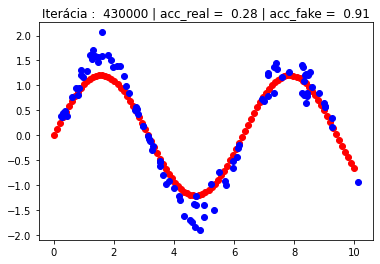

439999 0.3100000023841858 0.8199999928474426


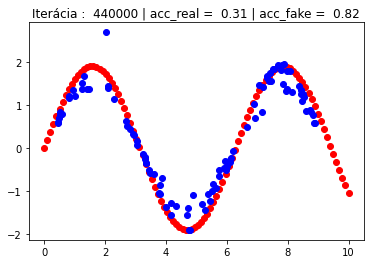

449999 0.36000001430511475 0.8399999737739563


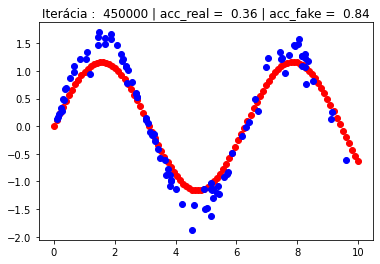

459999 0.28999999165534973 0.8600000143051147


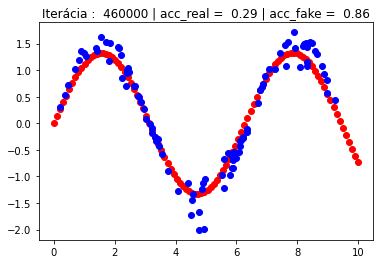

469999 0.3799999952316284 0.7699999809265137


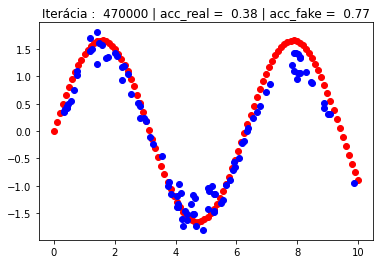

479999 0.27000001072883606 0.8299999833106995


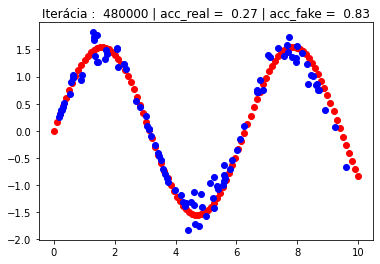

489999 0.25999999046325684 0.7200000286102295


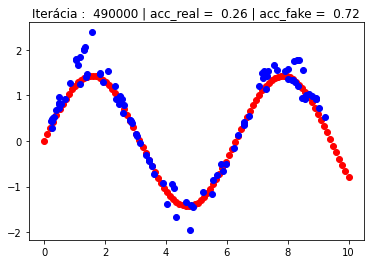

499999 0.3499999940395355 0.8299999833106995


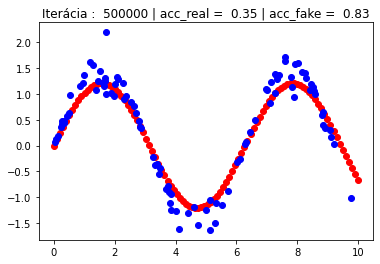

509999 0.18000000715255737 0.8100000023841858


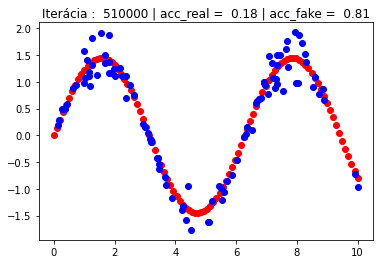

519999 0.18000000715255737 0.7599999904632568


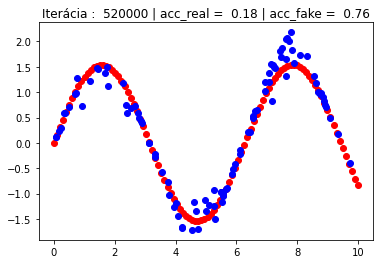

529999 0.27000001072883606 0.7699999809265137


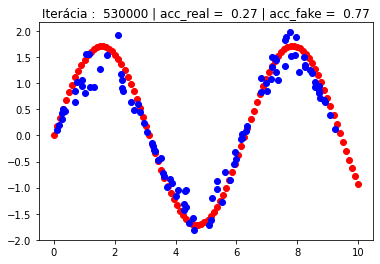

539999 0.5299999713897705 0.6800000071525574


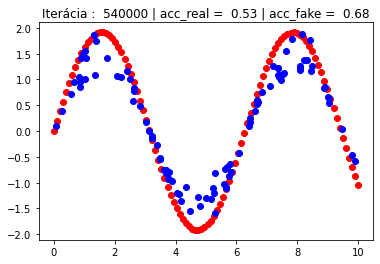

549999 0.3499999940395355 0.7699999809265137


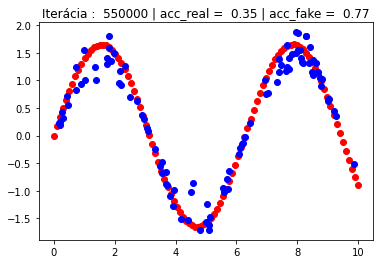

559999 0.44999998807907104 0.6700000166893005


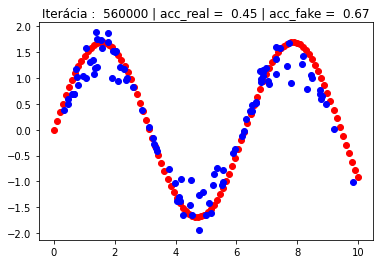

569999 0.2800000011920929 0.800000011920929


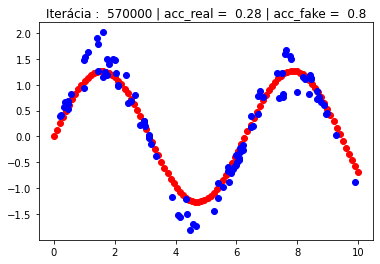

579999 0.27000001072883606 0.8500000238418579


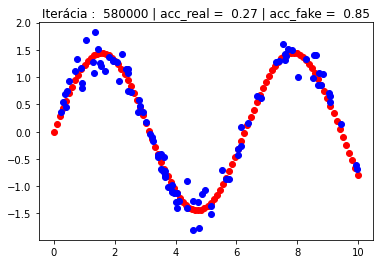

589999 0.27000001072883606 0.75


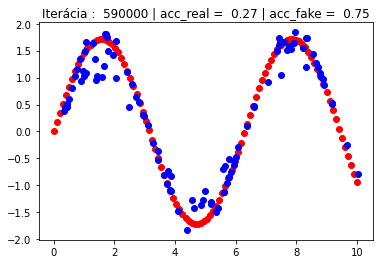

599999 0.33000001311302185 0.8399999737739563


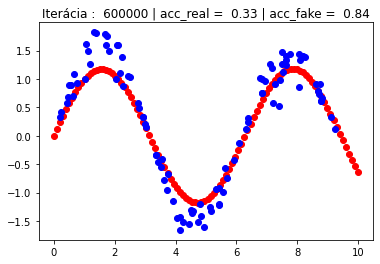

609999 0.2800000011920929 0.7599999904632568


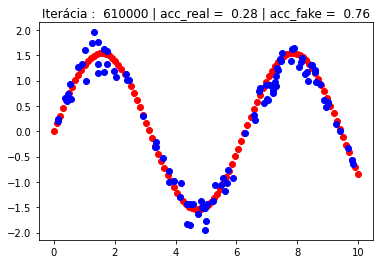

619999 0.25 0.7099999785423279


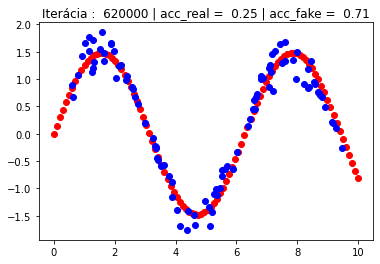

629999 0.5299999713897705 0.75


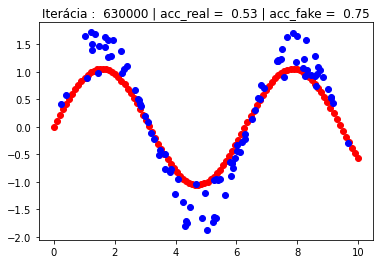

639999 0.25 0.699999988079071


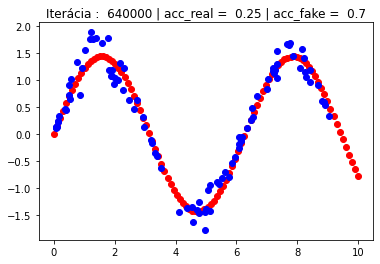

649999 0.4399999976158142 0.6700000166893005


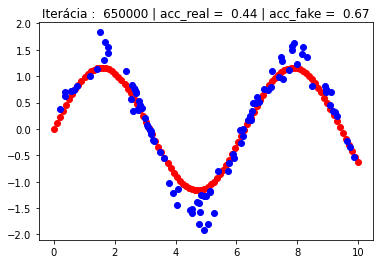

659999 0.46000000834465027 0.44999998807907104


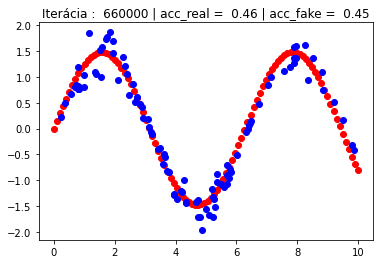

669999 0.25 0.8299999833106995


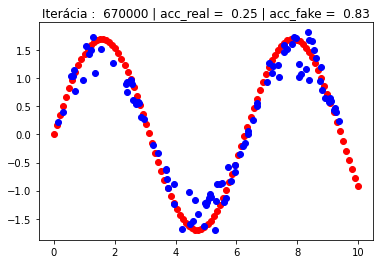

679999 0.6299999952316284 0.6800000071525574


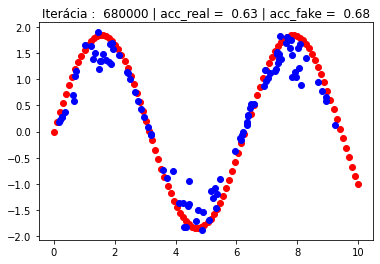

689999 0.4099999964237213 0.7799999713897705


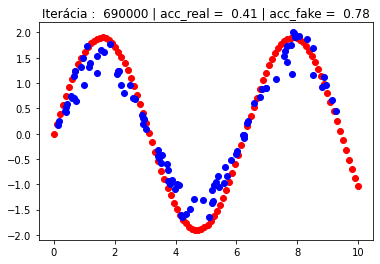

699999 0.5 0.75


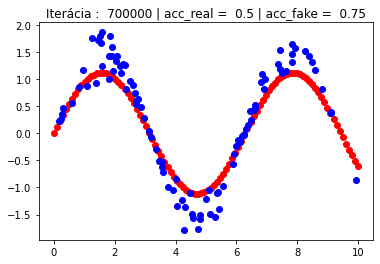

709999 0.18000000715255737 0.7400000095367432


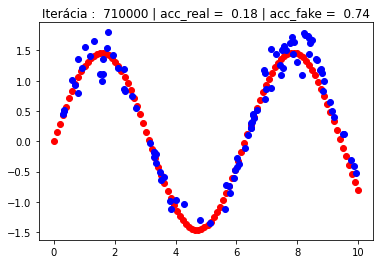

719999 0.36000001430511475 0.7300000190734863


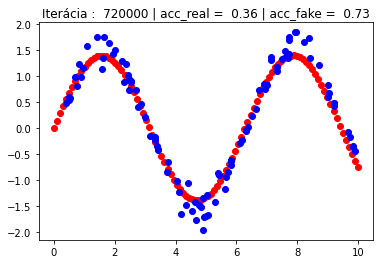

729999 0.3700000047683716 0.7900000214576721


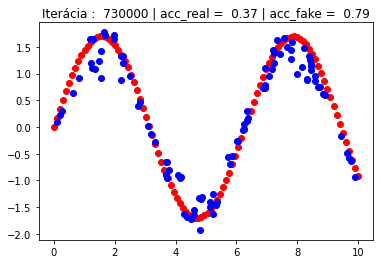

739999 0.47999998927116394 0.7900000214576721


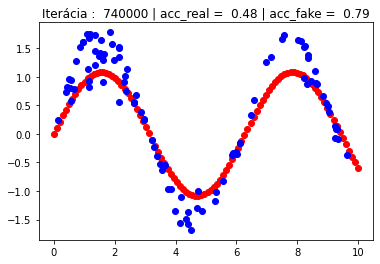

749999 0.4399999976158142 0.7900000214576721


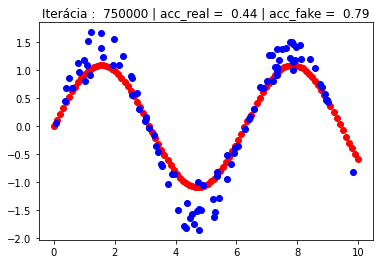

759999 0.550000011920929 0.6800000071525574


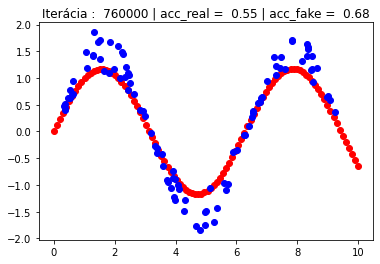

769999 0.41999998688697815 0.6800000071525574


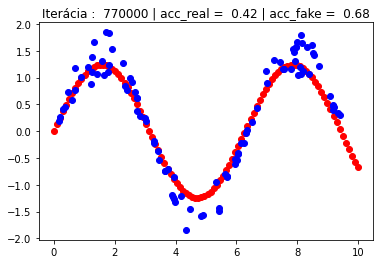

779999 0.4699999988079071 0.8399999737739563


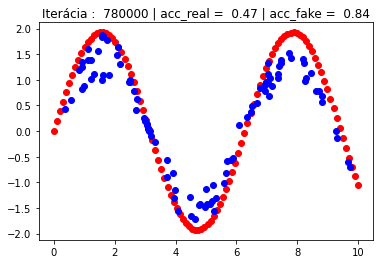

789999 0.5699999928474426 0.7099999785423279


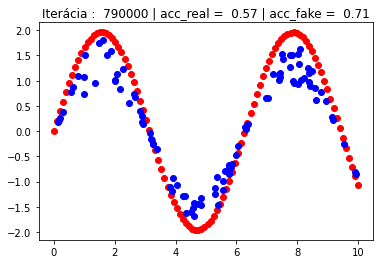

799999 0.41999998688697815 0.5899999737739563


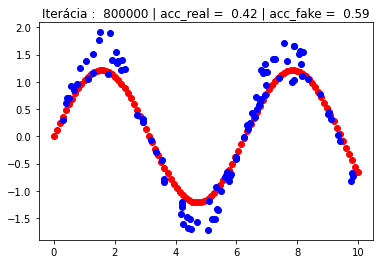

809999 0.2199999988079071 0.7900000214576721


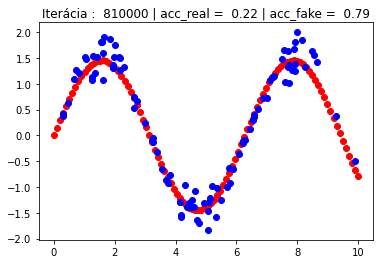

819999 0.3499999940395355 0.75


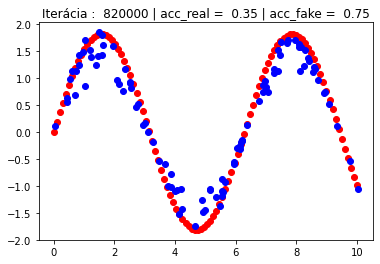

829999 0.20999999344348907 0.8100000023841858


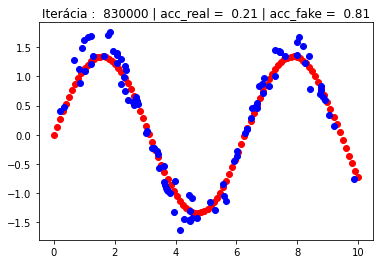

839999 0.3100000023841858 0.8299999833106995


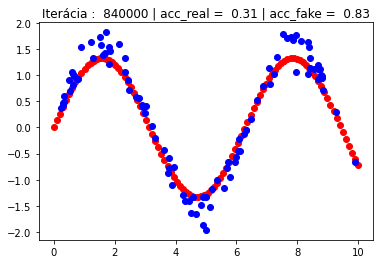

849999 0.4000000059604645 0.6899999976158142


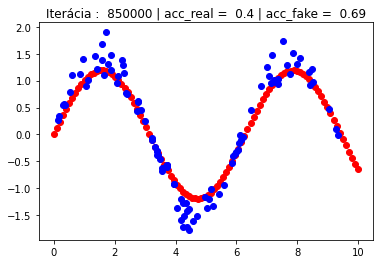

859999 0.20999999344348907 0.699999988079071


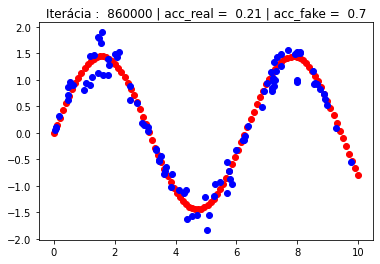

869999 0.30000001192092896 0.75


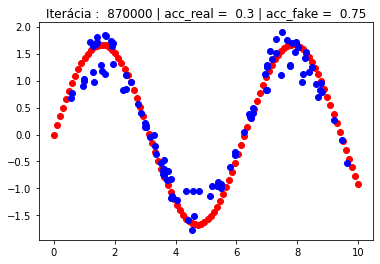

879999 0.4399999976158142 0.7799999713897705


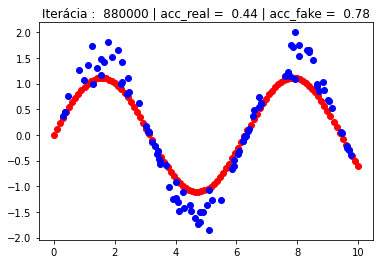

889999 0.2199999988079071 0.75


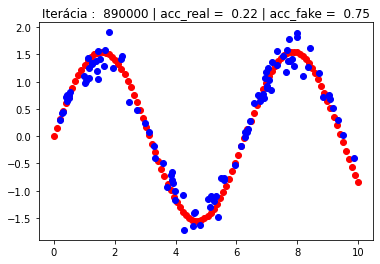

899999 0.23000000417232513 0.7300000190734863


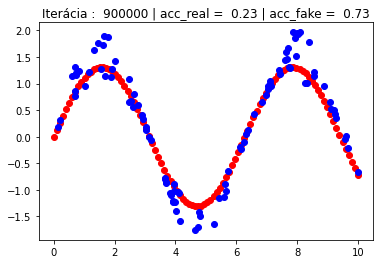

909999 0.18000000715255737 0.8799999952316284


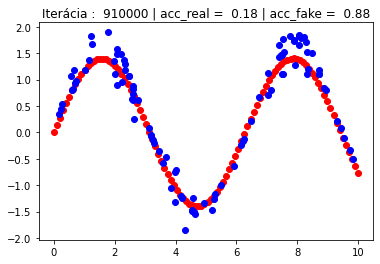

919999 0.2199999988079071 0.6800000071525574


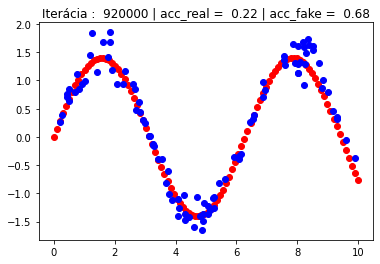

929999 0.6499999761581421 0.7099999785423279


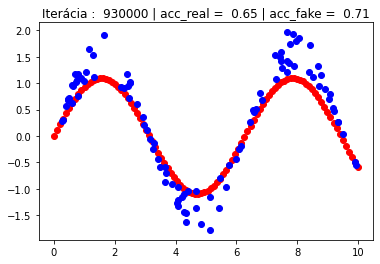

939999 0.14000000059604645 0.8100000023841858


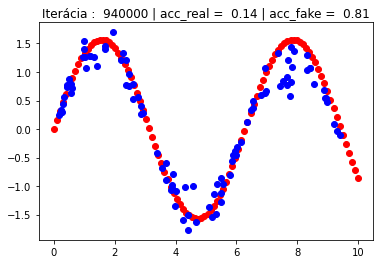

949999 0.1899999976158142 0.7699999809265137


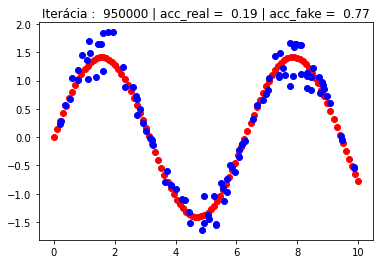

959999 0.23999999463558197 0.75


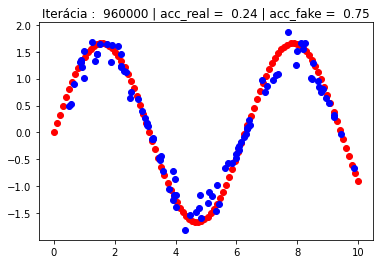

969999 0.46000000834465027 0.7300000190734863


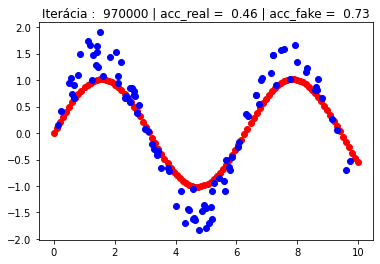

979999 0.5799999833106995 0.7300000190734863


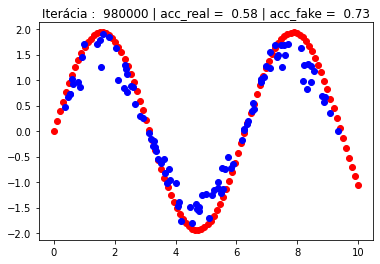

989999 0.33000001311302185 0.8299999833106995


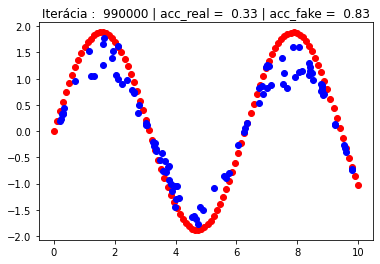

999999 0.33000001311302185 0.8100000023841858


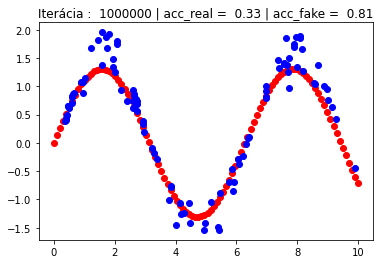

Time of training:
20434.407103334


In [12]:
start = timer()

def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25,  kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(15))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(10))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(5))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(1, activation='sigmoid'))
	# compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
  model = Sequential()
  model.add(Dense(50, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
  model.add(Dense(n_outputs, activation='linear'))
  return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	model.compile(loss='binary_crossentropy', optimizer='adam')
	return model

# generate n real samples with class labels
def generate_real_samples(n):
  # generate inputs in [0,5000]
  X1 = np.linspace(0,10,n)
  # generate outputs 
  X2 = (np.random.random(1)+1)*np.sin(X1) 
  # stack arrays
  X1 = X1.reshape(n, 1)
  X2 = X2.reshape(n, 1)
  X = hstack((X1, X2))
  # generate class labels
  y = ones((n, 1))
  return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
	# generate points in the latent space
	x_input = randn(latent_dim * n)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n, 1))
	return X, y

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
	# prepare real samples
	x_real, y_real = generate_real_samples(n)
	# evaluate discriminator on real examples
	_, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
	# evaluate discriminator on fake examples
	_, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print(epoch, acc_real, acc_fake)
	# scatter plot real and fake data points
	pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
	pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
	# plt.xlabel('x',fontsize=12)
	# plt.ylabel('y',fontsize=12)
	pyplot.title('Iterácia :'+ "  " + str(epoch+1)+" | "+'acc_real ='+"  "+str(np.round(acc_real,4))+" | "+'acc_fake ='+"  "+str(np.round(acc_fake,4)))
	pyplot.show()
	# if (acc_fake > 0.475) and (acc_fake < 0.525) and (acc_real > 0.475) and (acc_real < 0.525) and epoch>200000:
	# 	print('Model is trained')
	# 	a=1/0

def train(generator_model, discriminator_model, gan_model, latent_dim, n_epochs=1000000, n_batch=512,n_eval=10000):
	# determine half the size of one batch, for updating the discriminator
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare real samples
		x_real, y_real = generate_real_samples(half_batch)
		# prepare fake examples
		x_fake, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch) # generator model instead of random numbers
		# update discriminator
		d_real_loss,d_real_acc=discriminator_model.train_on_batch(x_real, y_real)
		d_fake_loss,d_fake_acc=discriminator_model.train_on_batch(x_fake, y_fake)
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		g_loss=gan_model.train_on_batch(x_gan, y_gan)
		d_real_loss_graph2.append(d_real_loss)
		d_real_acc_graph2.append(d_real_acc)
		d_fake_loss_graph2.append(d_fake_loss)
		d_fake_acc_graph2.append(d_fake_acc)
		g_loss_graph2.append(g_loss)
  # evaluate the model every n_eval epochs
		if (i+1) % n_eval == 0:
		  summarize_performance(i, generator_model, discriminator_model, latent_dim)

d_real_loss_graph2=[]
d_real_acc_graph2=[]
d_fake_loss_graph2=[]
d_fake_acc_graph2=[]
g_loss_graph2=[]
# size of the latent space
latent_dim = 5
# create the discriminator
discriminator2 = define_discriminator()
# create the generator
generator2 = define_generator(latent_dim)
# create the gan
gan_model2 = define_gan(generator2, discriminator2)
# train model
train(generator2, discriminator2, gan_model2, latent_dim)



end = timer()
print('Time of training:') 
print(end - start) #20434.407103334=340minut
np.save(WORKDIR_PATH / "d_real_loss_graph12",d_real_loss_graph2)
np.save(WORKDIR_PATH / "d_real_acc_graph12",d_real_acc_graph2)
np.save(WORKDIR_PATH / "d_fake_loss_graph12",d_fake_loss_graph2)
np.save(WORKDIR_PATH / "d_fake_acc_graph12",d_fake_acc_graph2)
np.save(WORKDIR_PATH / "g_loss_graph12",g_loss_graph2)


### Plotting losses and accuracies
SINUS

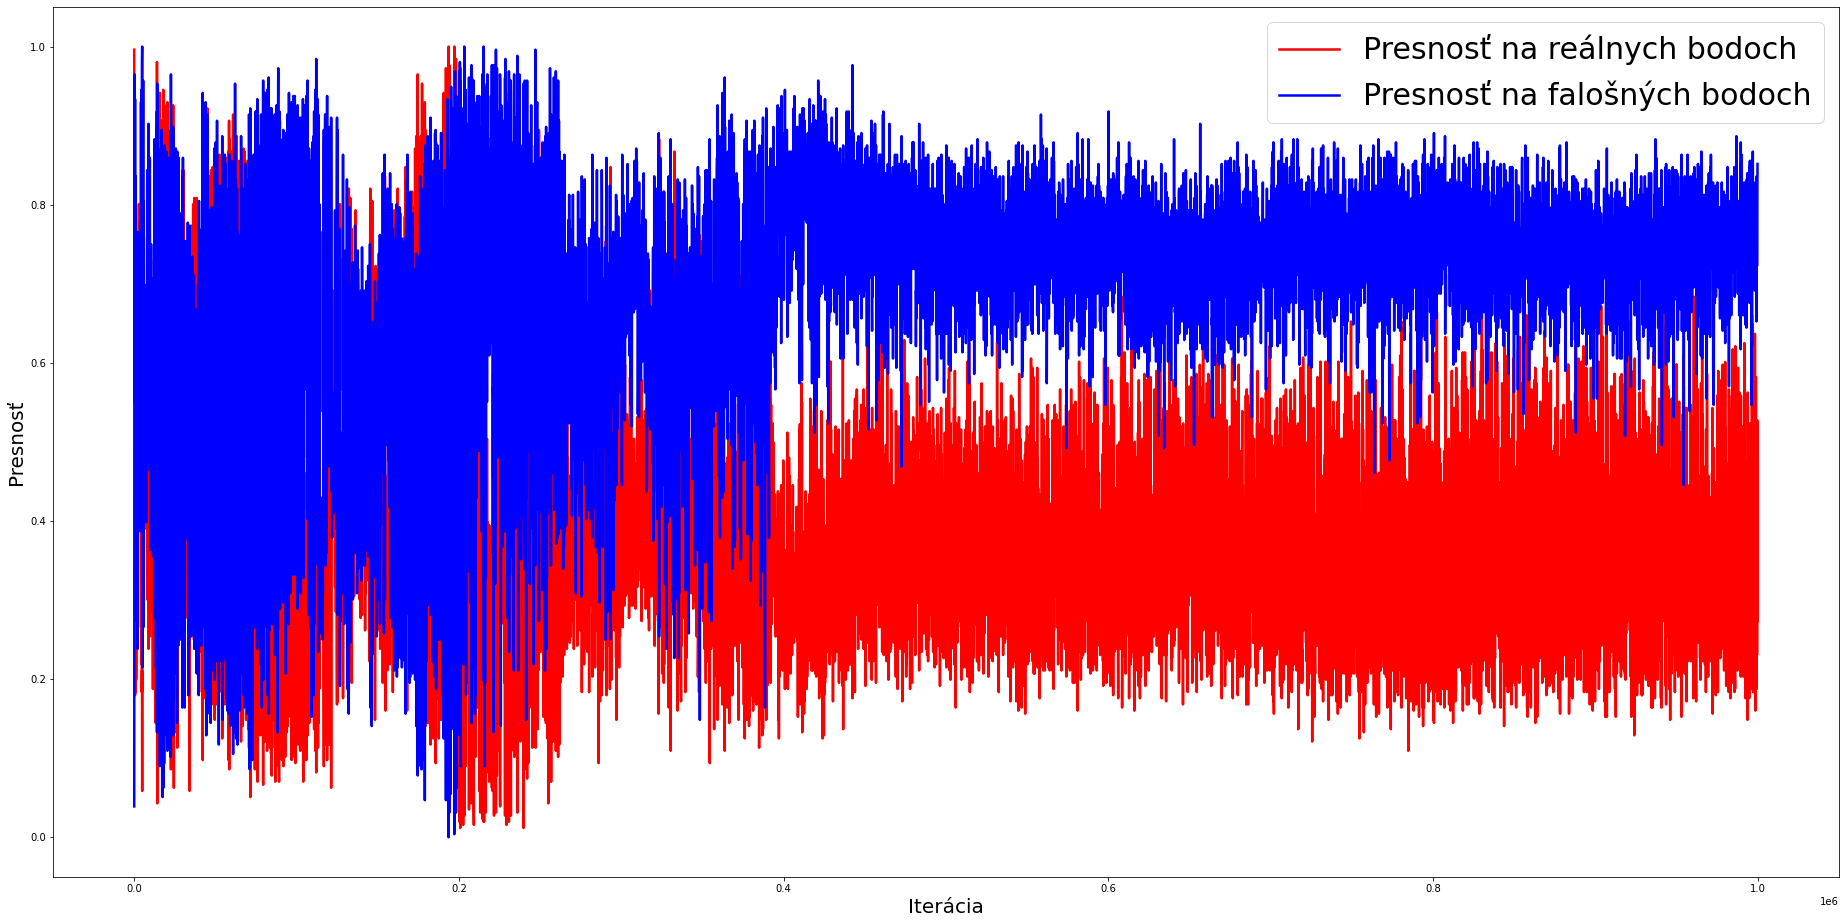

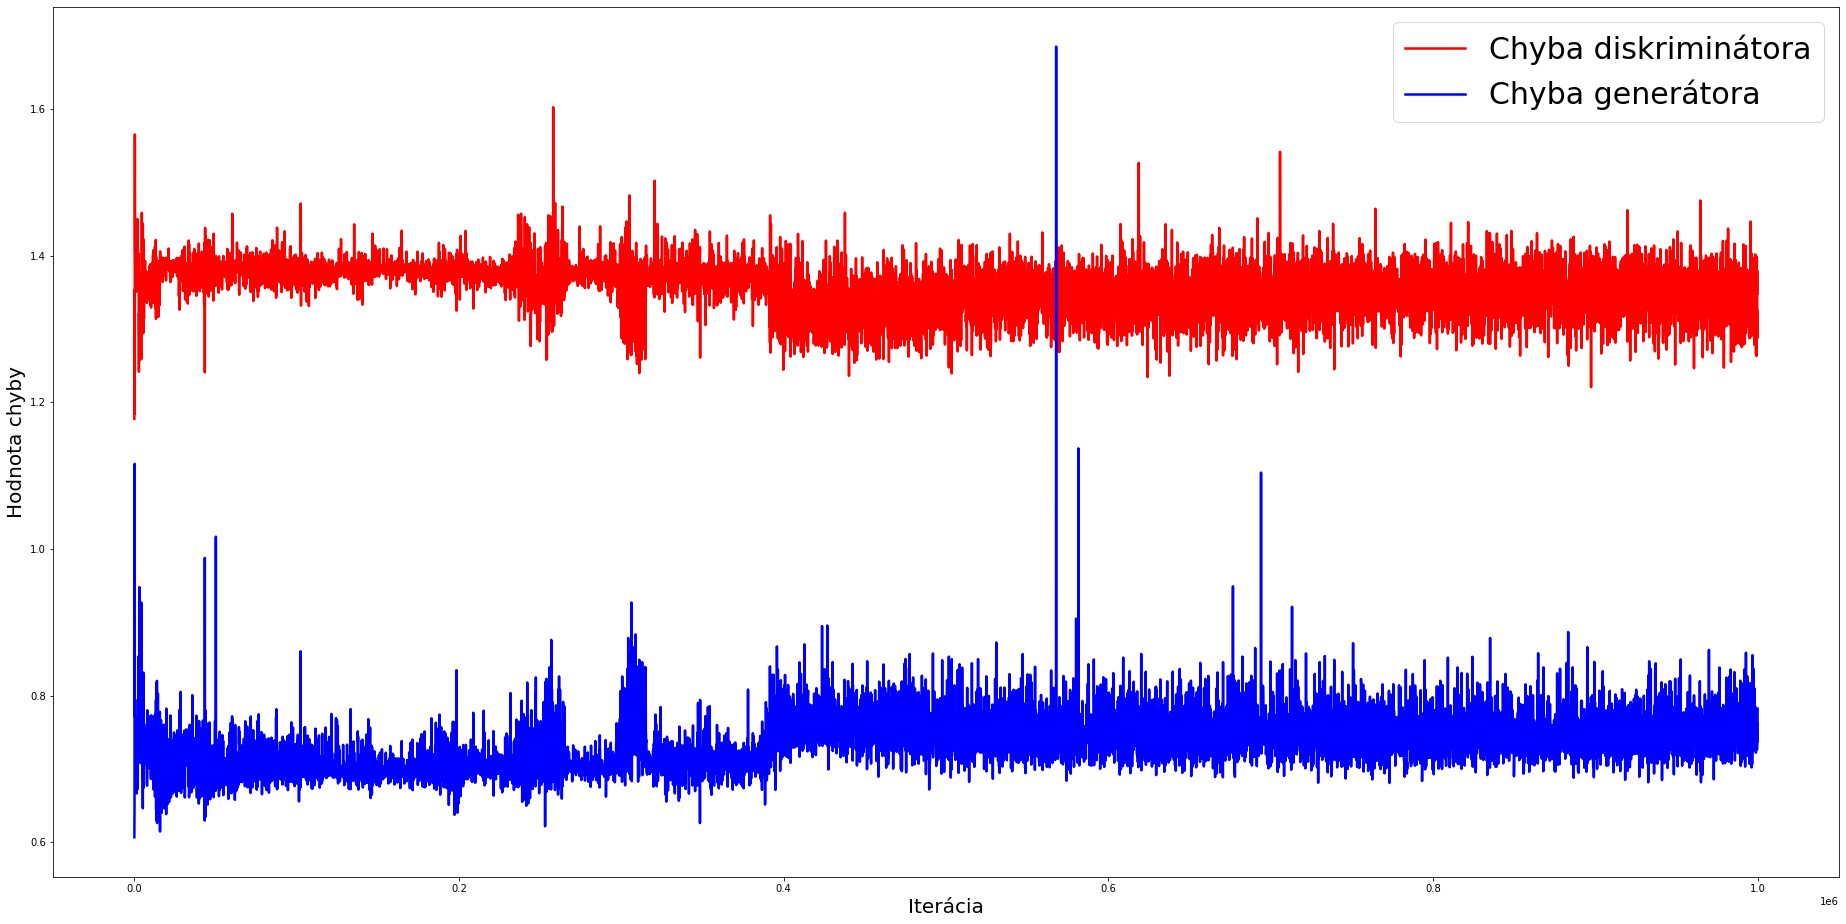

In [15]:
filtered_acc_real2 = [ item for i,item in enumerate(d_real_acc_graph2) if i%100==0 ]
filtered_acc_fake2 = [ item for i,item in enumerate(d_fake_acc_graph2) if i%100==0 ]

time_axis=np.linspace(0,1000000,10000)
fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Presnosť na reálnych bodoch', 'x': time_axis, 'y': filtered_acc_real2[:], 'color':'r', 'linewidth':2.5},{'name': 'Presnosť na falošných bodoch', 'x': time_axis, 'y': filtered_acc_fake2[:], 'color':'b', 'linewidth':2.5}]
for signal in mysignals:
	#ax1 = fig.add_subplot(n, n, 1 + i)
	plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
	#ax1.axis('off')
	plt.legend(loc='upper right',prop={'size': 30})
	plt.xlabel('Iterácia',fontsize=20)
	plt.ylabel('Presnosť',fontsize=20)

time_axis=np.linspace(0,1000000,10000)
d_loss_total2= np.array(d_real_loss_graph2)+np.array(d_fake_loss_graph2)

filtered_loss_real2 = [ item for i,item in enumerate(d_loss_total2) if i%100==0 ]
filtered_loss_fake2 = [ item for i,item in enumerate(g_loss_graph2) if i%100==0 ]

fig = plt.figure(figsize=(32,16))
mysignals = [{'name': 'Chyba diskriminátora', 'x': time_axis, 'y': filtered_loss_real2[:], 'color':'r', 'linewidth':2.5},{'name': 'Chyba generátora', 'x': time_axis, 'y': filtered_loss_fake2[:], 'color':'b', 'linewidth':2.5}]
for signal in mysignals:
	#ax1 = fig.add_subplot(n, n, 1 + i)
	plt.plot(signal['x'],signal['y'], color=signal['color'], linewidth=signal['linewidth'], label=signal['name'])
	#ax1.axis('off')
	plt.legend(loc='upper right',prop={'size': 30})
	plt.xlabel('Iterácia',fontsize=20)
	plt.ylabel('Hodnota chyby',fontsize=20)

## **Testing generators**

### x^2

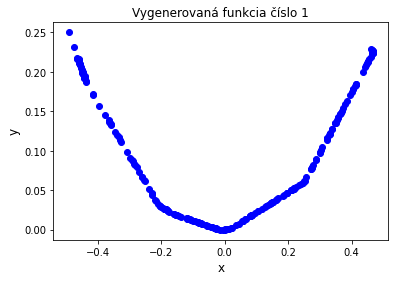

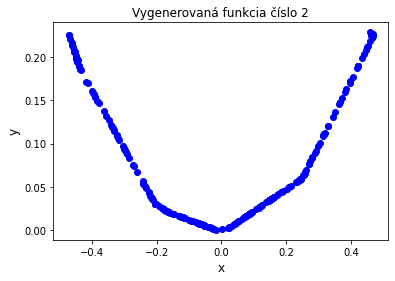

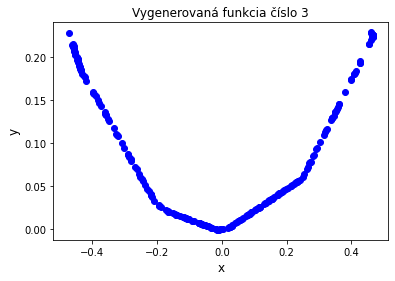

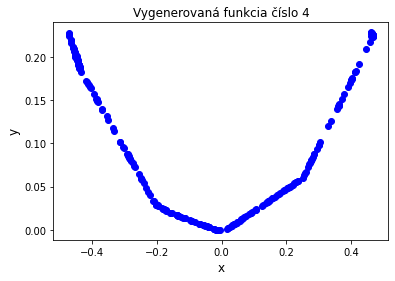

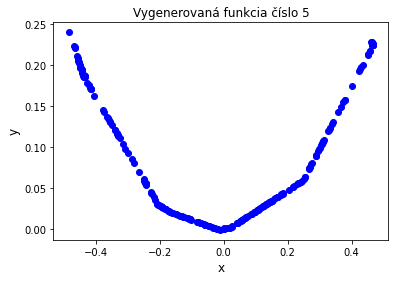

In [192]:
# X^2
for i in range(5): 
  x_fake=[]
  y_fake=[]
  x_fake, y_fake = generate_fake_samples(generator, 5, 250)
  pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
  plt.xlabel('x',fontsize=12)
  plt.ylabel('y',fontsize=12)
  plt.title('Vygenerovaná funkcia číslo'+' '+str(i+1))
  pyplot.show()

### SINUS

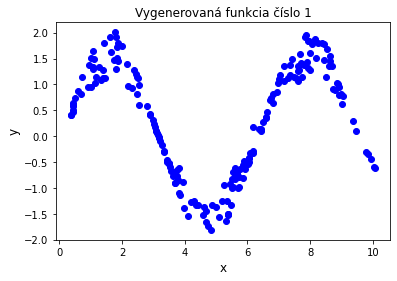

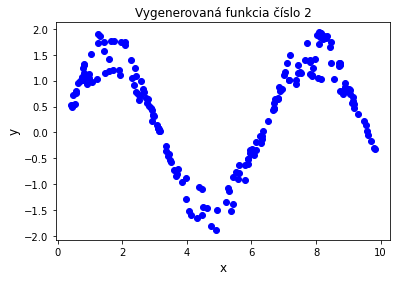

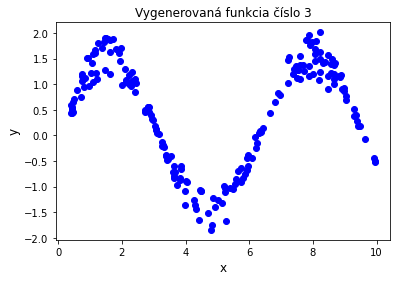

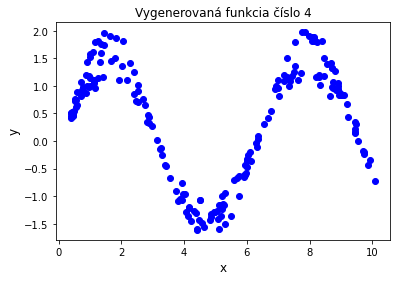

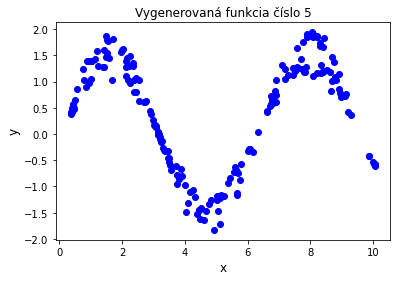

In [21]:
# SINUS
for i in range(5): 
  x_fake=[]
  y_fake=[]
  x_fake, y_fake = generate_fake_samples(generator2, 5, 200)
  pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
  plt.xlabel('x',fontsize=12)
  plt.ylabel('y',fontsize=12)
  plt.title('Vygenerovaná funkcia číslo'+' '+str(i+1))
  pyplot.show()

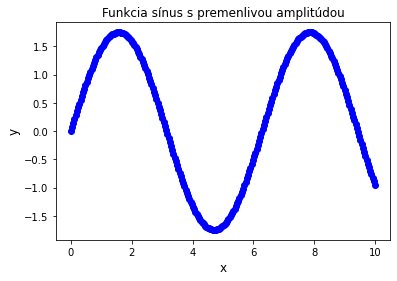

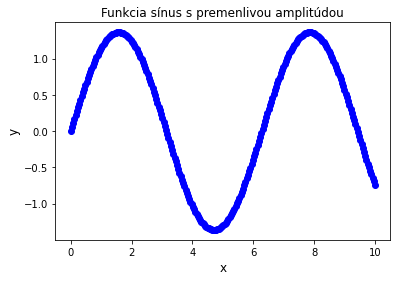

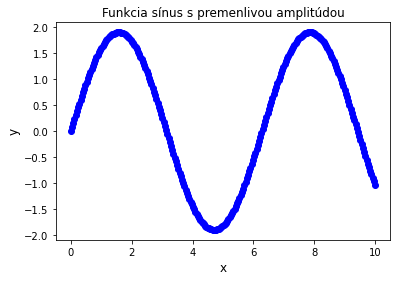

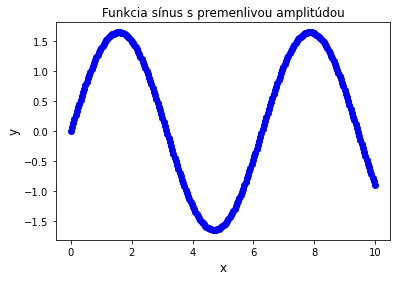

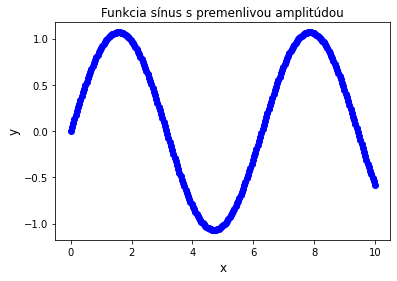

In [25]:
# generate n real samples with class labels
def generate_real_samples(n):
  # generate inputs in [0,5000]
  X1 = np.linspace(0,10,n)
  # generate outputs 
  X2 = (np.random.random(1)+1)*np.sin(X1) 
  # stack arrays
  X1 = X1.reshape(n, 1)
  X2 = X2.reshape(n, 1)
  X = hstack((X1, X2))
  # generate class labels
  y = ones((n, 1))
  return X, y
# SINUS
for i in range(5): 
  x_fake=[]
  y_fake=[]
  x_fake, y_fake = generate_real_samples(250)
  pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
  plt.xlabel('x',fontsize=12)
  plt.ylabel('y',fontsize=12)
  plt.title('Funkcia sínus s premenlivou amplitúdou')
  pyplot.show()
